## Kaytoo | Model Evaluation & Validating Inference
### Bird Call Classification for New Zealand 
This notebook builds the inference code for Kaytoo, and evaluates its performance.  The final functions and classes for actual deployment are to be moved into seperate `.py` scripts, so I can import them consistently into the inference `.py` script for deployment.

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [68]:
dummy_cell = 0

In [1]:
notebook_use = {
                'project_root': '/home/olly/Desktop/Kaggle_BC25', 
                'experiment': '124',
                'max_per_class' : 100,
                'threshold' : 0.5,
                'bird_name_csv': 'Data/Experiments/Exp_91/Exp_91_Deploy/exp_91_bird_map.csv',
                'folder_to_process': 'Data/Original_Data/birdclef-2025/train_soundscapes',
                'num_cores': 4  #Can crank this up if using CPU only.
                }

## Imports

In [2]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from IPython.display import Image, display
import re
import yaml

#External classes and functions
from bird_naming_utils import BirdNamer
from kaytoo_infer import  inference, ImageDataset, Models, get_images

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Machine Learning 
#import albumentations as A
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

#Torch and PyTorch specific
#import timm
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import pytorch_lightning as pl
from torch.utils.data import  DataLoader
#from torchaudio.functional import compute_deltas

#Audio
import librosa
#import torchaudio
from scipy.signal import resample

print('Imports Complete')

Imports Complete


## Configuration Classes

In [3]:
class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1
        self.classes = bird_namer.bird_list

In [4]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [5]:
class FilePaths:
    AUDIO_TYPES = {'.ogg','.wav', '.flac', '.mp3'}
    def __init__(self, options=None):
        self.root_folder = Path(options['project_root'])
        self.data_folder = self.root_folder / 'Data'
        self.train_audios = self.data_folder / 'Original_Data/birdclef-2025/train_audio'
        self.experiment_results = self.data_folder / f"Experiments/Exp_{options['experiment']}/Results"
        self.prev_model_preds = self.experiment_results / f"exp_{options['experiment']}_soundscape_predictions.csv"
        self.val_csv = self.experiment_results / 'val_labels.csv'
        self.bird_list_path = self.root_folder / options['bird_name_csv']
        self.soundscapes_folder = self.root_folder /options['folder_to_process']
        self.soundscapes = [path for path in self.soundscapes_folder.rglob('*') if path.suffix in self.AUDIO_TYPES]
        self.new_backgrounds = self.data_folder / f"Cropped_Train_Soundscapes_{options['experiment']}"
        self.predictions_dir = self.data_folder / 'Soundscape_Predictions'        
        self.learning_rate_monitor = self.experiment_results / f"exp_{options['experiment']}_training_metrics.jpg"
        self.train_metric_monitor = self.experiment_results / 'learning_rate.jpg'
        self.val_preds = self.experiment_results / 'val_pred_df.pkl'
        self.val_targs = self.experiment_results / 'val_target_df.pkl'
        self.labels_parquet = self.data_folder / 'Train_Metadata' / f"background_labels_{options['experiment']}.parquet"

        self.new_backgrounds.mkdir(parents=True, exist_ok=True)


## Helper Functions

In [6]:
class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

## Initialise

In [7]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, 
                    options=notebook_use)


## Analysis of Training Metrics

### Class Sizes and Distributions

First lets look at the classes and their sizes.

In [8]:
bird_map_df = bird_map_df.sort_values(by='TrainSamples').reset_index(drop=True)
bird_map_df.head(50)

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
0,rutpuf1,Russet-throated Puffbird,Hypnelus ruficollis,aves,18,3.0
1,42007,Mountain Lion,Puma concolor,mamalia,19,2.0
2,1139490,Ragoniella pulchella,Ragoniella pulchella,insecta,20,0.0
3,21116,Yellow-striped Poison Dart Frog,Dendrobates truncatus,amphibia,20,0.0
4,1194042,Copiphora colombiae,Copiphora colombiae,insecta,20,0.0
5,47067,Brown-throated Three-toed Sloth,Bradypus variegatus,mamalia,20,0.0
6,476537,Colombian Plump Frog,Elachistocleis pearsei,amphibia,20,0.0
7,476538,Panama Humming Frog,Elachistocleis panamensis,amphibia,20,0.0
8,523060,Eschatoceras bipunctatus,Eschatoceras bipunctatus,insecta,20,0.0
9,piwtyr1,Pied Water-Tyrant,Fluvicola pica,aves,20,0.0


In [9]:
bird_map_df[bird_map_df['eBird']=='52884'] 

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
112,52884,True Crickets,Gryllidae,insecta,106,11.0


In [10]:
bird_map_df[bird_map_df['eBird']=='compot1'] 

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
186,compot1,Common Potoo,Nyctibius griseus,aves,430,47.0


In [11]:
rarest = bird_map_df[bird_map_df['TrainSamples'] + bird_map_df['ValSamples'] <= 50]['eBird'].to_list()
print(rarest)

['rutpuf1', '42007', '1139490', '21116', '1194042', '47067', '476537', '476538', '523060', 'piwtyr1', 'plctan1', '24272', '24322', '24292', '41778', '528041', 'turvul', '548639', '65349', '65419', 'shghum1', 'sahpar1', '555142', '64862', '65336', '65344', '81930', '868458', '714022', '787625', '963335', '66016', '65962', '65547', '41970', '1192948', '21038', '66531', '66578', '66893', '67082', '126247', '42113', '1346504', '134933', '42087', '1462711', '46010', '1462737', '1564122', 'norscr1', '67252', 'bubcur1', 'ampkin1', 'bafibi1', '566513', '135045', '65373', 'grysee1', '715170', 'blctit1', '555086', 'whmtyr1', 'royfly1', 'cocher1', '48124', 'olipic1', 'woosto']


In [12]:
from matplotlib.ticker import LogLocator

In [13]:
def plot_continuous(df, column_name, x_max=None, x_min=None, bins=None):
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[column_name], bins=bins, kde=True)
    ax.set_yscale("log", base=2)  # Log scale with base 2
    ax.yaxis.set_major_locator(LogLocator(base=2.0, numticks=10))  # Control ticks
    plt.title(f'Distribution of {column_name} with {bins} Bins and KDE')
    plt.xlabel(column_name)
    ax.set(ylim=(1,40000))
    ax.set(xlim=(x_min, x_max) if x_min is not None and x_max is not None else None)
    plt.ylabel('Count')
    plt.show()

In [14]:
csv_files = list(paths.predictions_dir.glob("*.csv"))
dfs = []
for path in csv_files:
    print(path)
    df = pd.read_csv(path)
    dfs.append(df)
    print(df.iloc[:5, :5])

/home/olly/Desktop/Kaggle_BC25/Data/Soundscape_Predictions/soundscape_predictions_93.csv
                   row_id   1139490   1192948   1194042    126247
0   H27_20230421_155000_0  0.074326  0.032609  0.076026  0.041163
1   H27_20230421_155000_3  0.074326  0.032609  0.076026  0.041163
2   H27_20230421_155000_6  0.074326  0.032609  0.076026  0.041163
3   H27_20230421_155000_9  0.074326  0.032609  0.076026  0.041163
4  H27_20230421_155000_12  0.074326  0.032609  0.076026  0.041163
/home/olly/Desktop/Kaggle_BC25/Data/Soundscape_Predictions/soundscape_predictions_96.csv
                   row_id   1139490   1192948  1194042    126247
0   H27_20230421_155000_0  0.016933  0.009449  0.02136  0.040656
1   H27_20230421_155000_3  0.016933  0.009449  0.02136  0.040656
2   H27_20230421_155000_6  0.016933  0.009449  0.02136  0.040656
3   H27_20230421_155000_9  0.016933  0.009449  0.02136  0.040656
4  H27_20230421_155000_12  0.016933  0.009449  0.02136  0.040656
/home/olly/Desktop/Kaggle_BC25/Data/

In [15]:
# Preserve 'file_id' from the first DataFrame
result = pd.DataFrame()
result['row_id'] = dfs[0]['row_id']

# Get all columns except 'file_id'
value_columns = [col for col in dfs[0].columns if col != 'row_id']

# Stack and average the other columns
values_mean = sum(df[value_columns] for df in dfs) / len(dfs)

# Combine them
df = pd.concat([result, values_mean], axis=1)
df.head(30)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_0,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
1,H27_20230421_155000_3,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
2,H27_20230421_155000_6,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
3,H27_20230421_155000_9,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
4,H27_20230421_155000_12,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
5,H27_20230421_155000_15,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
6,H27_20230421_155000_18,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
7,H27_20230421_155000_21,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
8,H27_20230421_155000_24,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352
9,H27_20230421_155000_27,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.080310,0.141009,0.160316,0.118845,0.177352


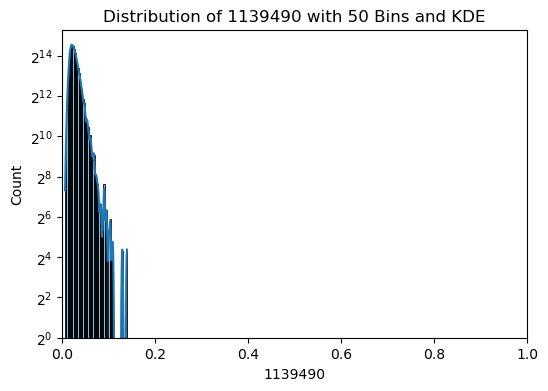

In [16]:
plot_continuous(df, '1139490', x_min = 0, x_max=1, bins=50)

In [17]:
#for bird in df.columns.to_list()[1:]:
#    print(bird)
#    plot_continuous(df.copy(), bird, x_min = 0, x_max=1, bins=50)

In [18]:
df_max = df.iloc[:, 1:].copy()
df_max['max_score'] = df_max.max(axis=1)
df_max.head(20)

,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,1564122,...,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar,max_score
0,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
1,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
2,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
3,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
4,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
5,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
6,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
7,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
8,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223
9,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,0.056535,...,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352,0.387223


In [19]:
df_max.shape

(194520, 207)

In [20]:
count = (df_max['max_score'] > 0.5).sum()
count

66920

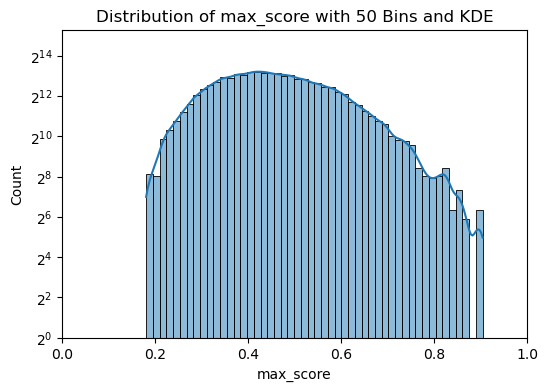

In [21]:
plot_continuous(df_max, 'max_score', x_min = 0, x_max=1, bins=50)

In [22]:
df_numeric = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')  # ensure numeric
df_max['second_from_max'] = df_numeric.apply(
    lambda row: row.nlargest(2).iloc[-1] if row.count() > 1 else row.max(),
    axis=1
)

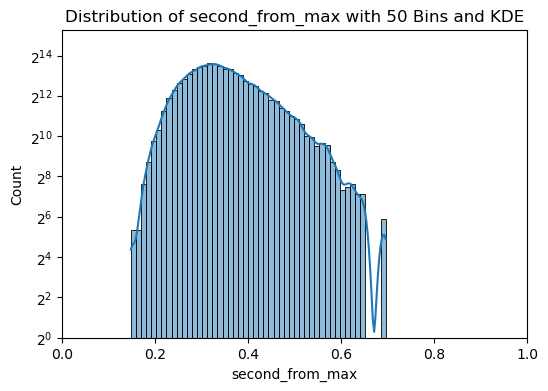

In [23]:
plot_continuous(df_max, 'second_from_max', x_min = 0, x_max=1, bins=50)

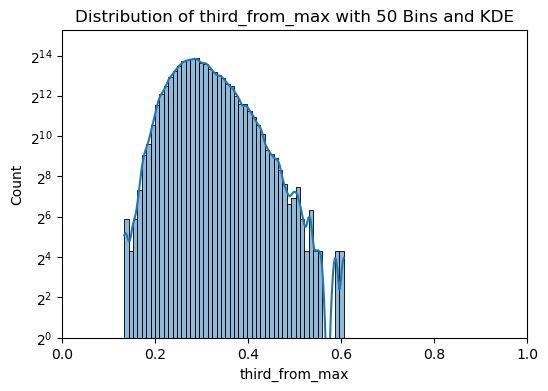

In [24]:
df_numeric = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')  # ensure numeric
df_max['third_from_max'] = df_numeric.apply(
    lambda row: row.nlargest(3).iloc[-1] if row.count() > 1 else row.max(),
    axis=1
)
plot_continuous(df_max, 'third_from_max', x_min = 0, x_max=1, bins=50)

In [25]:
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_0,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
1,H27_20230421_155000_3,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
2,H27_20230421_155000_6,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
3,H27_20230421_155000_9,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
4,H27_20230421_155000_12,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352


In [26]:
df.shape

(194520, 207)

In [27]:
threshold = 0.5
df_bin = df.copy()
# Identify numeric columns only
numeric_cols = df_bin.select_dtypes(include='number').columns

# Apply binary threshold
df_bin[numeric_cols] = (df_bin[numeric_cols] > threshold).astype(int)
df_bin = df_bin[~(df_bin.select_dtypes(include='number') == 0).all(axis=1)]
df_bin.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
140,H67_20230516_212000_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,H67_20230516_212000_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,H67_20230516_212000_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143,H67_20230516_212000_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,H67_20230516_212000_12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


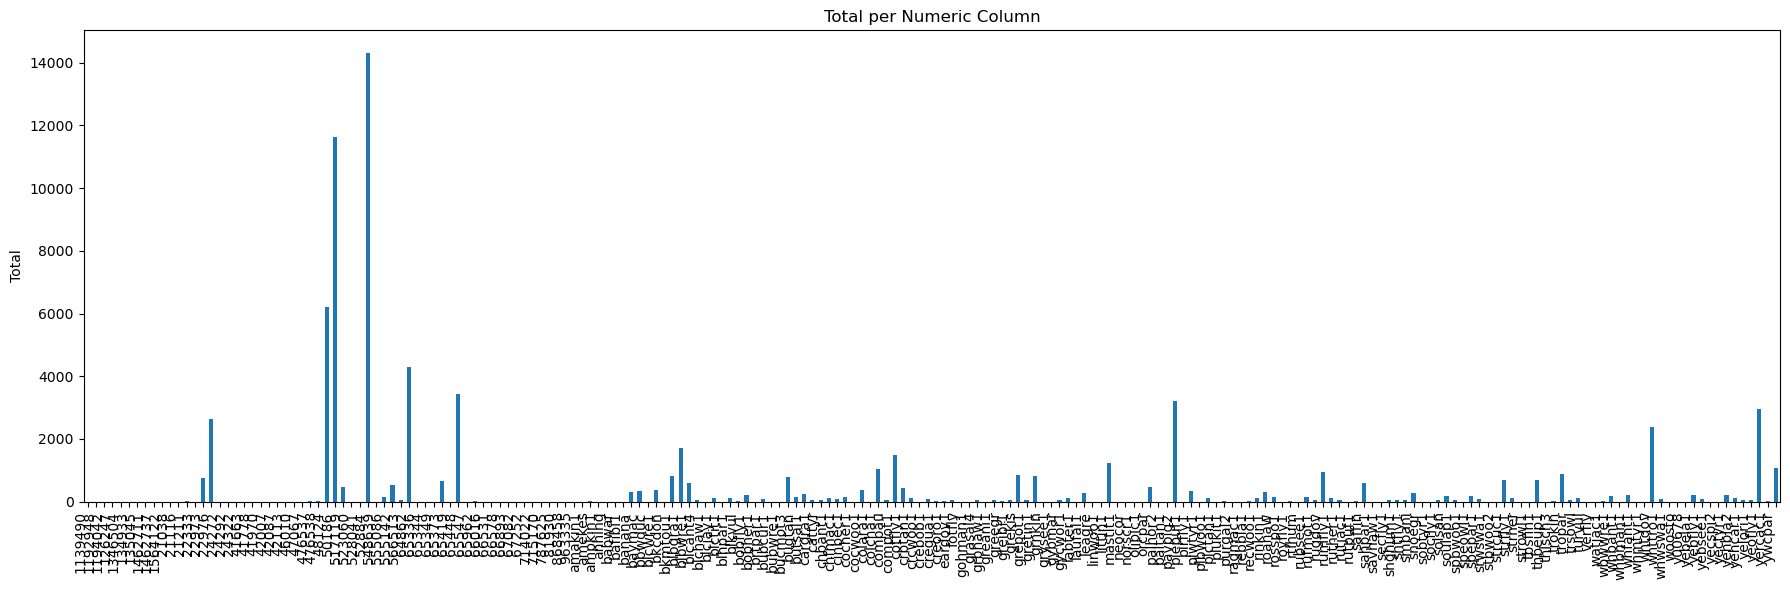

In [28]:
import matplotlib.pyplot as plt

# Sum each numeric column
column_totals = df_bin.select_dtypes(include='number').sum()

import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(18, 6))  # Width=12 inches, Height=6 inches

# Sum and plot
column_totals = df_bin.select_dtypes(include='number').sum()
column_totals.plot(kind='bar')
plt.ylabel('Total')
plt.title('Total per Numeric Column')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [29]:
for total, name in zip(column_totals, df.columns.tolist()[1:]):
    if total > 1000:
        print(name, total)

22976 2620
48124 6220
50186 11620
52884 14320
64862 4300
65448 3420
blbgra1 1700
colcha1 1040
compot1 1500
littin1 1220
pavpig2 3200
whtdov 2380
yeofly1 2960
ywcpar 1080


compot1, has over 6000 samples.  But only 300 in the training data   It's some kind of owl, so this is believable from night soundscapes
52884 is a common cricket, so not surprising at all.  And there are just 33 training samples!

Let's start again, but since we have so many owl and compot1 samples to burn, set a really high threshold for those two.


In [30]:
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_0,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
1,H27_20230421_155000_3,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
2,H27_20230421_155000_6,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
3,H27_20230421_155000_9,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352
4,H27_20230421_155000_12,0.026571,0.014898,0.031311,0.036126,0.088399,0.035901,0.027275,0.023932,0.024334,...,0.121717,0.115719,0.084296,0.142069,0.089997,0.08031,0.141009,0.160316,0.118845,0.177352


In [31]:
default_thresh = notebook_use['threshold']
custom_thresholds = {
    'compot1': .55,  #Was 0.65 for exps 83 on,  put back to 0.7 for exp 92
    '52884': .75,
    'pavpig2' :0.62,
    '65448':0.65,
    #### New ones
    '64862':0.75,
    '50186':0.63,
    '48124':0.63,
    '22976':0.65,
    'whtdov':0.6,
    'yeofly1':0.65,
    'rugdov': 0.55,
    'pavpig2':0.62,
    'littin1':0.55,
    'colcha1': 0.58,
    'blbgra1': 0.58,
    'ywcpar': 0.55,
}

In [32]:
class_scores = df.iloc[:, 1:]
class_limit = notebook_use['max_per_class']
min_threshold = notebook_use['threshold']

# Compute thresholds: each is the value above which there are at most 500 values
thresholds = class_scores.apply(lambda col: col.nlargest(class_limit).min(), axis=0)

# Optional: convert to dictionary
all_thresholds = thresholds.to_dict()
all_thresholds = {key:round(max(val,min_threshold),3) for key, val in all_thresholds.items()}
all_thresholds

{'1139490': 0.5,
 '1192948': 0.5,
 '1194042': 0.5,
 '126247': 0.5,
 '1346504': 0.5,
 '134933': 0.5,
 '135045': 0.5,
 '1462711': 0.5,
 '1462737': 0.5,
 '1564122': 0.5,
 '21038': 0.5,
 '21116': 0.5,
 '21211': 0.5,
 '22333': 0.5,
 '22973': 0.682,
 '22976': 0.834,
 '24272': 0.5,
 '24292': 0.5,
 '24322': 0.5,
 '41663': 0.5,
 '41778': 0.5,
 '41970': 0.5,
 '42007': 0.5,
 '42087': 0.5,
 '42113': 0.5,
 '46010': 0.5,
 '47067': 0.5,
 '476537': 0.5,
 '476538': 0.5,
 '48124': 0.687,
 '50186': 0.682,
 '517119': 0.699,
 '523060': 0.5,
 '528041': 0.5,
 '52884': 0.829,
 '548639': 0.5,
 '555086': 0.584,
 '555142': 0.569,
 '566513': 0.5,
 '64862': 0.849,
 '65336': 0.5,
 '65344': 0.5,
 '65349': 0.5,
 '65373': 0.719,
 '65419': 0.5,
 '65448': 0.756,
 '65547': 0.5,
 '65962': 0.5,
 '66016': 0.5,
 '66531': 0.5,
 '66578': 0.5,
 '66893': 0.5,
 '67082': 0.5,
 '67252': 0.5,
 '714022': 0.5,
 '715170': 0.5,
 '787625': 0.5,
 '81930': 0.5,
 '868458': 0.5,
 '963335': 0.5,
 'amakin1': 0.5,
 'amekes': 0.5,
 'ampkin1': 0.

In [33]:
# Keep the first column (row_id)
df_binary = df[['row_id']].copy()

# Apply thresholding to the rest
thresholded = df.drop(columns='row_id').apply(
    lambda col: (col > all_thresholds.get(col.name, min_threshold)).astype(int)
)

# Optionally filter out rows where all numeric columns are 0
thresholded = thresholded[~(thresholded == 0).all(axis=1)]

# Merge row_id back for the remaining rows
df_binary = df[['row_id']].loc[thresholded.index].join(thresholded)

df_binary.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
580,H71_20230512_132500_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,H71_20230512_132500_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,H71_20230512_132500_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
583,H71_20230512_132500_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
584,H71_20230512_132500_12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


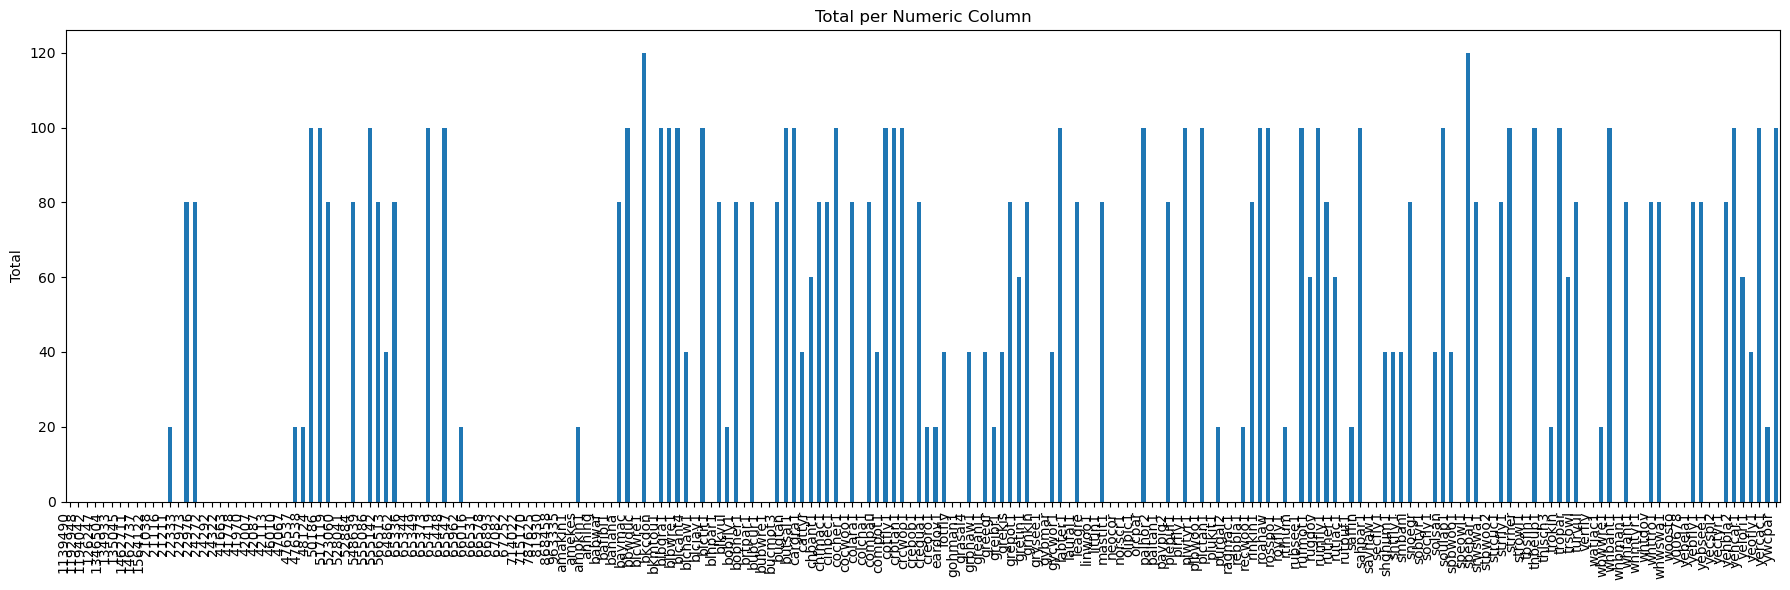

In [34]:
# Sum each numeric column
column_totals = df_binary.select_dtypes(include='number').sum()

import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(18, 6))  # Width=12 inches, Height=6 inches

# Sum and plot
column_totals = df_binary.select_dtypes(include='number').sum()
column_totals.plot(kind='bar')
plt.ylabel('Total')
plt.title('Total per Numeric Column')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [35]:
df_balanced = df_binary.copy()
df_balanced.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
580,H71_20230512_132500_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,H71_20230512_132500_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,H71_20230512_132500_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
583,H71_20230512_132500_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
584,H71_20230512_132500_12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_balanced.shape

(7380, 207)

In [37]:
df_balanced.shape

(7380, 207)

In [38]:
df_balanced['52884'].sum()

80

In [39]:
df_balanced['compot1'].sum()

100

In [40]:
df_bin = df_balanced.copy()
df_bin['start'] = (
    df_bin['row_id']
    .str.extract(r'_(\d+)$')[0]   # Extract number at the end
    .astype(int)        # Apply your scaling because the orignal notebook labelled wrong
).round().astype(int)  
df_bin['end'] = df_bin['start'] + 6

In [41]:
# Example input column
import re
df_bin['filename'] = df_bin.apply(
    lambda row: re.sub(r'_[^_]+$', f"_{row['end']}.ogg", row['row_id']),
    axis=1
)

name_cols = df_bin.columns.to_list()[1:-3]
df_bin = df_bin[['filename', 'row_id', 'start', 'end'] + name_cols]


In [42]:
df_bin['row_id'] = df_bin['row_id'].str.replace(r'_[^_]+$', '.ogg', regex=True)

In [43]:
df_bin.head()

,filename,row_id,start,end,1139490,1192948,1194042,126247,1346504,134933,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
580,H71_20230512_132500_6.ogg,H71_20230512_132500.ogg,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,H71_20230512_132500_9.ogg,H71_20230512_132500.ogg,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,H71_20230512_132500_12.ogg,H71_20230512_132500.ogg,6,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
583,H71_20230512_132500_15.ogg,H71_20230512_132500.ogg,9,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
584,H71_20230512_132500_18.ogg,H71_20230512_132500.ogg,12,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_bin.shape

(7380, 210)

In [45]:
import torchaudio
import soundfile as sf

def load_file(path):
    try:
        waveform, sr = torchaudio.load(path)
        y = waveform.numpy()
        if y.shape[0] == 2:
            y = y.mean(axis=0)
        else:
            y = y.squeeze()

        loaded_length = len(y)//sr
        if loaded_length <= 1:
            print(f'Warning, the loaded clip length is only {loaded_length} seconds for the file {path}')
        return y, sr
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        return None, None


def process_group(row_id,
                  group, 
                 in_folder = paths.soundscapes_folder,
                 out_folder = paths.new_backgrounds,
                 default_sr = 32000):
    filename = row_id
    in_path = str(in_folder / filename)

    #print(in_path)
    y, sr = load_file(in_path)

    if y is not None:
        #append 3 secs from the start to the end, as was done during evaluation
        start_segment = y[:sr*3]
        y = np.concatenate([y, start_segment]) 
        

        for _, row in group.iterrows():
            start=row.start * sr
            end = row.end * sr
            part = y[start:end]
            if len(part) >=1:
                out_path = str(out_folder / row.filename)
                if sr != default_sr:
                    num_samples = int(len(part) * default_sr / sr)
                    part = resample(part, num_samples)
                sf.write(out_path, part, default_sr)
    return

In [46]:
df_bin.head()

,filename,row_id,start,end,1139490,1192948,1194042,126247,1346504,134933,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
580,H71_20230512_132500_6.ogg,H71_20230512_132500.ogg,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,H71_20230512_132500_9.ogg,H71_20230512_132500.ogg,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,H71_20230512_132500_12.ogg,H71_20230512_132500.ogg,6,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
583,H71_20230512_132500_15.ogg,H71_20230512_132500.ogg,9,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
584,H71_20230512_132500_18.ogg,H71_20230512_132500.ogg,12,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
from joblib import Parallel, delayed
from tqdm import tqdm
grouped = df_bin.groupby('row_id')
# Wrap tqdm around list to show progress
results = Parallel(n_jobs=-1)(  # Use all available cores
    delayed(process_group)(row_id, group)
    for row_id, group in tqdm(grouped)
)

100%|██████████| 369/369 [00:29<00:00, 12.65it/s]


In [48]:
df_bin = df_bin[['filename'] + name_cols].reset_index(drop=True)

In [49]:
df_bin.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H71_20230512_132500_6.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H71_20230512_132500_9.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H71_20230512_132500_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230512_132500_15.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230512_132500_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df_bin.to_parquet(paths.labels_parquet)

In [51]:
df_check = pd.read_parquet(paths.labels_parquet)
df_check.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H71_20230512_132500_6.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H71_20230512_132500_9.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H71_20230512_132500_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230512_132500_15.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230512_132500_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df_check = df_check.loc[:, (df_check != 0).any(axis=0)]
df_check.columns.shape

(106,)

In [53]:
rarest

['rutpuf1',
 '42007',
 '1139490',
 '21116',
 '1194042',
 '47067',
 '476537',
 '476538',
 '523060',
 'piwtyr1',
 'plctan1',
 '24272',
 '24322',
 '24292',
 '41778',
 '528041',
 'turvul',
 '548639',
 '65349',
 '65419',
 'shghum1',
 'sahpar1',
 '555142',
 '64862',
 '65336',
 '65344',
 '81930',
 '868458',
 '714022',
 '787625',
 '963335',
 '66016',
 '65962',
 '65547',
 '41970',
 '1192948',
 '21038',
 '66531',
 '66578',
 '66893',
 '67082',
 '126247',
 '42113',
 '1346504',
 '134933',
 '42087',
 '1462711',
 '46010',
 '1462737',
 '1564122',
 'norscr1',
 '67252',
 'bubcur1',
 'ampkin1',
 'bafibi1',
 '566513',
 '135045',
 '65373',
 'grysee1',
 '715170',
 'blctit1',
 '555086',
 'whmtyr1',
 'royfly1',
 'cocher1',
 '48124',
 'olipic1',
 'woosto']

In [54]:
df_rare = df_bin[['filename'] + rarest].copy()
df_rare.head()

,filename,rutpuf1,42007,1139490,21116,1194042,47067,476537,476538,523060,...,grysee1,715170,blctit1,555086,whmtyr1,royfly1,cocher1,48124,olipic1,woosto
0,H71_20230512_132500_6.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H71_20230512_132500_9.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H71_20230512_132500_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230512_132500_15.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230512_132500_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df_rare.columns

Index(['filename', 'rutpuf1', '42007', '1139490', '21116', '1194042', '47067',
       '476537', '476538', '523060', 'piwtyr1', 'plctan1', '24272', '24322',
       '24292', '41778', '528041', 'turvul', '548639', '65349', '65419',
       'shghum1', 'sahpar1', '555142', '64862', '65336', '65344', '81930',
       '868458', '714022', '787625', '963335', '66016', '65962', '65547',
       '41970', '1192948', '21038', '66531', '66578', '66893', '67082',
       '126247', '42113', '1346504', '134933', '42087', '1462711', '46010',
       '1462737', '1564122', 'norscr1', '67252', 'bubcur1', 'ampkin1',
       'bafibi1', '566513', '135045', '65373', 'grysee1', '715170', 'blctit1',
       '555086', 'whmtyr1', 'royfly1', 'cocher1', '48124', 'olipic1',
       'woosto'],
      dtype='object')

In [56]:
df_rare.shape

(7380, 69)

In [57]:
df_rare = df_rare.loc[:, (df_rare != 0).any(axis=0)]
df_rare.head()

,filename,rutpuf1,476537,476538,shghum1,555142,64862,65962,566513,65373,555086,royfly1,48124
0,H71_20230512_132500_6.ogg,0,0,0,0,0,0,0,0,0,0,0,0
1,H71_20230512_132500_9.ogg,0,0,0,0,0,0,0,0,0,0,0,0
2,H71_20230512_132500_12.ogg,0,0,0,0,0,0,0,0,0,0,0,0
3,H71_20230512_132500_15.ogg,0,0,0,0,0,0,0,0,0,0,0,0
4,H71_20230512_132500_18.ogg,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
df_rare.shape

(7380, 13)

In [59]:
column_totals_df = df.sum(axis=0).to_frame(name="total")
column_totals_df

,total
row_id,H27_20230421_155000_0H27_20230421_155000_3H27_...
1139490,5443.728256
1192948,3347.996613
1194042,6255.3387
126247,9056.624749
...,...
yehcar1,14833.07402
yelori1,11803.144471
yeofly1,35729.96893
yercac1,17026.23691


In [60]:
import plotly.express as px

column_totals = df_rare.sum(axis=0).reset_index()
column_totals.columns = ['Category', 'Count']

fig = px.bar(column_totals, x='Category', y='Count', title='Column Totals')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [61]:
65349, 'sahpar1', 81930, 868458, 65962, 65547, 21038, 66531, 66578, 66893, 126247, 1346504, 134933, 'bafibi1', 65373, 

(65349,
 'sahpar1',
 81930,
 868458,
 65962,
 65547,
 21038,
 66531,
 66578,
 66893,
 126247,
 1346504,
 134933,
 'bafibi1',
 65373)

In [62]:
label_counts_df = pd.read_csv(paths.data_folder / 'Train_Metadata/primary_label_counts.csv')
label_counts_df = label_counts_df[label_counts_df['primary_label'].isin(rarest)]
label_counts_df.head(40)

,Unnamed: 0,primary_label,total_count
133,133,royfly1,40
134,134,cocher1,40
137,137,olipic1,38
138,138,whmtyr1,34
141,141,blctit1,32
142,142,65373,32
144,144,ampkin1,28
145,145,woosto,27
146,146,bafibi1,27
147,147,555086,25


In [63]:
df_filtered = pd.read_parquet(paths.labels_parquet)
df_filtered.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H71_20230512_132500_6.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H71_20230512_132500_9.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H71_20230512_132500_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H71_20230512_132500_15.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H71_20230512_132500_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
df_filtered.shape

(7380, 207)

In [65]:
#for name in rarest:
#    df_filtered = df_filtered[df_filtered[name]==0]

In [66]:
df_filtered.shape

(7380, 207)

In [67]:
#df.to_parquet('/home/olly/Desktop/Kaggle_BC25/Data/Train_Metadata/background_labels.parquet')